# Calcium-Induced Calcium Release (CICR) Model

This notebook models calcium-induced calcium release (CICR) originally inspired by the Dawson et al. model. We solve for Ca$^{2+}$ dynamics in a spatial domain using an explicit finite difference approach, incorporating Ca$^{2+}$ mediated Ca$^{2+}$ channel activation, Ca$^{2+}$ diffusion, and a Ca$^{2+}$-dependent sink.

The governing equation for Ca$^{2+}$ concentration, $Ca^{2+}(x, t)$, is:

$$
\frac{\partial Ca^{2+}}{\partial t} = D \frac{\partial^2 Ca^{2+}}{\partial x^2} + \sigma \sum_i \delta(x - x_i) H(t - t_i) H(t_i + \tau - t) + \sigma_S \delta(x - L/2) H(\tau_S - t) - V_{\text{sink,max}} \frac{\left(Ca^{2+} - Ca_b\right)^n}{\left(Ca^{2+} - Ca_b\right)^n + K_m^n}
$$

### Key Components

![Grid Definition](figures/supp-9A-grid-schematic.png)

- **Activation of Ca$^{2+}$ Channels**: In the equations, t$_{i}$ denotes the time at which a Ca$^{2+}$ channel becomes activated in response to local Ca$^{2+}$ levels. When the local Ca$^{2+}$ concentration exceeds a threshold value of Ca$_{T}$, the Ca$^{2+}$ channel is activated with a refractory time of $\tau$ minutes. The strength of the Ca$^{2+}$ release is represented by the rate at which Ca$^{2+}$ is released upon the opening, denoted as $\sigma$. $\delta$ and H denotes Dirac-Delta and Heaviside functions respectively.


- **Initiator Site**: $\sigma_S$ represents the flux at the center of domain which is used to represent the initiator site. $\tau_S$ represents the time for which the point source is active. 


- **Diffusion and Boundary conditions**: The spatial domain extends over $L = 700 \, \mu m$, and free diffusion beyond $-250 \, \mu m$ and $250 \, \mu m$ prevents boundary accumulation. Following boundary conditions were used for simulations:

$$
\text{Ca}^{2+} (x = \frac{L}{2}) = \text{Ca}_b
$$

$$
\text{Ca}^{2+} (x = -\frac{L}{2}) = \text{Ca}_b
$$


- **Calcium-Dependent Sink**: The modeling of a Ca$^{2+}$ dependent sink assumes that Ca$^{2+}$ binding occurs rapidly, keeping the process in equilibrium. In this model, we consider that each binding event requires n Ca$^{2+}$ ions, with forward and backward rate constants kf and kb, respectively, for Ca2+ binding and unbinding. Based on these assumptions, we derive

  $$
  f_{\text{bound}} = \frac{\left(Ca^{2+}\right)^n}{k_b/k_f + \left(Ca^{2+}\right)^n}
  $$

### Parameters Table

| Parameter           | Definition                                           | Units          |
|---------------------|------------------------------------------------------|----------------|
| $\sigma_S$          | Source/Initiator site flux                           | $\mu$M/$min$ |
| $\tau_S$            | Source activation time                               | min           |
| $D$                 | Diffusion coefficient                                | $\mu$m$^2$/min |
| $\sigma$            | Activation strength of Ca$^{2+}$ channel             | $\mu$M/$min$ |
| $\tau$              | Activation time of Ca$^{2+}$ channel                 | min           |
| $d$                 | Distance between Ca$^{2+}$ channels                  | $\mu$m        |
| $V_{\text{sink,max}}$ | Max flux of Ca$^{2+}$ through sink                | $\mu$M/$min$ |
| $K_m$               | Ca$^{2+}$ conc. for half saturation of sink          | $\mu$M        |
| $n$                 | Number of Ca$^{2+}$ ions needed for sink activation  | -             |
| $Ca_b$              | Basal Ca$^{2+}$ concentration                        | $\mu$M        |
| $Ca_T$              | Threshold Ca$^{2+}$ conc. for activation             | $\mu$M        |

### References

- Dawson SP, Keizer J, Pearson JE. Fire–diffuse–fire model of dynamics of intracellular calcium waves. Proceedings of the National Academy of Sciences. 1999 May 25;96(11):6060-3.

### Imports

In [1]:
import numpy as np
import scipy.stats as st
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import numba
from smt.sampling_methods import LHS
import os
import time

### Main functions

In [2]:
@numba.njit
def release_calcium(t, t_i, sigma, tau):
    """
    Determines the calcium release from a CICR (Calcium-Induced Calcium Release) site.
    
    Parameters:
    -----------
    t : float
        Current time in the simulation.
    t_i : float
        Time of initial activation for the CICR site.
    sigma : float
        Release strength or amount of calcium released per activation.
    tau : float
        Duration over which calcium release occurs once activated.
    
    Returns:
    --------
    float
        The calcium release amount at time `t`, which is `sigma` if within the activation period, 
        otherwise 0.
    """
    if t >= t_i and t <= t_i + tau:
        return sigma
    else:
        return 0
    
@numba.njit
def source_calcium(t, src_strength, src_rise_time):
    """
    Defines the calcium source at a central location, activated for a specific duration.
    
    Parameters:
    -----------
    t : float
        Current time in the simulation.
    src_strength : float
        Strength of the calcium source.
    src_rise_time : float
        Time until which the calcium source is active.
    
    Returns:
    --------
    float
        The calcium source strength at time `t`, which is `src_strength` if `t` is within the 
        source duration, otherwise 0.
    """
    if t <= src_rise_time:
        return src_strength
    else:
        return 0
    
@numba.njit
def cicr_ros_diff(Ca, dx, dt, time_steps, theta, include_sink):
    """
    Simulates calcium dynamics using reaction-diffusion with CICR and a Ca2+ dependent sink.
    
    Parameters:
    -----------
    Ca : ndarray
        Initial calcium concentration array with shape (space, time).
    dx : float
        Spatial resolution for the simulation grid.
    dt : float
        Temporal resolution for the simulation time steps.
    time_steps : int
        Total number of time steps in the simulation. 
    theta : list
        - src_center_strength (float): Source flux strength at the center.
        - src_center_actTime (float): Duration for the source flux.
        - sigma (float): Strength of calcium release at CICR sites.
        - tau (float): Duration of CICR activation.
        - d_sites (float): Distance between CICR sites.
        - Ca_threshold (float): Threshold calcium concentration to activate CICR.
        - km (float): Half-saturation constant for calcium sink.
        - nsink (float): Number of calcium ions needed for sink activation.
        - vmax (float): Maximum rate of calcium uptake by the sink.
    include_sink - Ture/False
        Adds a Ca2+ dependent sink to model if True

    Returns:
    --------
    tuple
        - Ca (ndarray): Updated calcium concentration array.
        - x_sites (ndarray): Spatial positions of CICR sites.
        - fired_init_times (ndarray): Initial activation times of CICR sites.
        - fired (ndarray): Activation status of CICR sites.
        - points2 (ndarray): Positions of CICR sites on one side of the central source.
    """
    
    ### Reading in model parameters inputs
    D = 1200 ### Fixed for pavement cells in plants 
    src_center_strength = theta[0]
    src_center_actTime = theta[1]
    sigma = theta[2] 
    tau = theta[3] 
    d_sites = theta[4]
    Ca_threshold = theta[5]
    km = theta[6]
    nsink = theta[7]
    vmax = theta[8]
    
    ### Initialzing the Ca2+ concentrations
    Ca_basal = 0.1 ### Fixed for pavement cells in plants 
    Ca = Ca + Ca_basal
    
    ### Generating points in the grid where CICR Ca2+ channels are located
    # Genenarting points on right hand side of source 
    L = 700
    points2 = np.arange(350+d_sites, 600, d_sites)
    points1List = []
    # Genenarting points on left hand side of source
    temp = 350
    for i in range(len(points2)):
        temp = temp - d_sites
        points1List.append(temp)
    points1Numpy = np.array(points1List)
    points1 = points1Numpy[::-1]
    # Merging CICR sites in grid. Initialzing arrau to store fired states and times of activation
    x_sites = np.concatenate((points1, points2))
    fired = np.zeros(len(x_sites), dtype=numba.boolean) ## np.zeros(len(x_sites), dtype=bool)
    fired_init_times = np.zeros(len(x_sites)) 
    
    ### Defining location of the initiator site within 1D grid
    idx_center = int(350 / dx)
    
    ### Printink Sink status
    if include_sink == True:
        print("Message: Sink is active in model")
    else:
        print("Message: No sink present within model")
    
    ### Solving reaction diffusion equations
    for t in range(1, time_steps): 
        # Diffusion
        Ca[1:-1, t] = Ca[1:-1, t-1] + D * dt / dx**2 * (Ca[2:, t-1] - 2 * Ca[1:-1, t-1] + Ca[:-2, t-1])
        Ca[0, t] = Ca_basal
        Ca[-1, t] = Ca_basal
        # Adding sink if include_sink == True
        if include_sink == True:
            sink_term = (vmax * ((Ca[:, t-1] - Ca_basal)**nsink)) / (km**nsink + (Ca[:, t-1]- Ca_basal)**nsink)
            Ca[:, t] -= dt * sink_term 
        # Defining source at the center 
        Ca[idx_center,t]+= dt*source_calcium(t*dt, src_center_strength, src_center_actTime)
        # Modeling CICR
        for i, x_i in enumerate(x_sites):
            idx = int(x_i / dx)
            if not fired[i] and Ca[idx, t-1] >= Ca_threshold:
                fired[i] = True  
                fired_init_times[i] = t * dt    
            if fired[i]:
                Ca[idx, t] += dt* release_calcium(t*dt, fired_init_times[i], sigma, tau)
                
    return Ca, x_sites, fired_init_times, fired, points2

def plotting_functions(Ca, x_sites, fired_init_times, fig_filename):
    """
    Generates and saves a plot visualizing calcium concentration over time and position from the simulation data.

    Parameters:
    -----------
    Ca : ndarray
        A 2D array representing the calcium concentration over time and space, where each column corresponds to a time step 
        and each row corresponds to a spatial point.
    x_sites : ndarray
        A 1D array of spatial positions (in µm) corresponding to the rows in the `Ca` array.
    fired_init_times : ndarray
        A 1D array of initial firing times (in minutes) for each activated calcium site.
    fig_filename : str
        Filename for saving the figures. The figures are saved within output-data folder created within teh root directory

    Returns:
    --------
    None
        This function saves the generated plot as an SVG file in the specified output directory.

    Notes:
    ------
    - The function first checks if the calcium data is finite and below a specified memory threshold (1 GB). If not, it
      prints a warning message regarding memory usage.
    - A plot is created using `imshow` to display the calcium concentration, with a color bar representing the concentration levels.
    - Scatter points indicate firing times.
    - The output figure is saved in a folder named 'output-data'.
    """
    
    ### Checking if the size of Ca2+ is within memory limits. Can cause issues if time step is too low.  
    Ca_size_in_gb = Ca.nbytes / (1024 ** 3) 
    memory_threshold_gb = 1.0
    
    if np.all(np.isfinite(Ca)):
        ### Making output directory if it doesnot exist
        output_folder = 'output-data'
        os.makedirs(output_folder, exist_ok=True)
        ### Defining figure properties
        fig, axs = plt.subplots(1, 1, figsize=(2.8, 3), dpi=200)
        ### Take only the Ca2+ data at every 100 time steps to save memory. Also visualize Ca for only half teh domain (350-700)
        Ca_sliced = Ca[:, ::100]
        half_index = Ca_sliced.shape[0] // 2
        Ca_sliced_half = Ca_sliced[half_index:, :]
        ### Displacing teh sliced Ca array as a heatmap
        im1 = axs.imshow(Ca_sliced_half, extent=[0, 4, 0, 350], aspect='auto', origin='lower', interpolation='nearest',
                         vmin = 0.1, vmax = 0.45)
        fig.colorbar(im1, ax=axs, label=r'$[Ca^{2+}]$ ($\mu M$)')
        ### Plotting experimental data of mean wave velocity +_ stdeve for 1um flg22 treatment
        time_points1 = np.linspace(0, 3.85, 100)
        y_positions1 = (1.35-0.27)* 60 * time_points1 ##+ 350
        axs.plot(time_points1, y_positions1, 'whitesmoke', linewidth=1.5, linestyle = '-')
        time_points2 = np.linspace(0, 2.57, 100)
        y_positions2 = (1.35+0.27)* 60 * time_points2 ##+ 350
        axs.plot(time_points2, y_positions2, 'whitesmoke', linewidth=1.5, linestyle = '-')
        ### Plotting the firing times of CICR channels
        axs.scatter(fired_init_times, x_sites-350, c='tab:red', s=10)
        ### Defining axis limits
        axs.set_ylim(0, 350)
        axs.set_xlim(0, 4)
        ### Labeling axes
        axs.set_xlabel('time (min)')
        axs.set_ylabel('position (µm)')        
        ### Saving and displaying the figure
        filename = os.path.join(output_folder, fig_filename + '.svg')
        plt.tight_layout()
        plt.savefig(filename)
        plt.show()
        plt.close(fig)
        
    else:
        print('Exceeds memory use.')

        
def main_model_1(theta, dx, dt, T, fig_filename, include_sink):
    """
    Simulates calcium dynamics using CICR (Calcium-Induced Calcium Release) with diffusion and sink.

    Parameters:
    -----------
    theta : list or ndarray
        Model parameters
    dx : float
        Spatial resolution for the simulation grid.
    dt : float
        Temporal resolution for the simulation time steps.
    T : float
        Total simulation time.
    fig_filename : str
        Filename for saving the figures. The figures are saved within output-data folder created within teh root directory
    include_sink : True/False
        If True the model incorporates a Ca2+ dependent sink. 
        If False it simulates the original model proposed by Dawson et. al without a sink
    
    Returns:
    --------
    tuple
        - average_velocity (float): Average velocity of calcium wave propagation based on activation times.
        - total_distance (float): Total distance traveled by the calcium wave across CICR sites.
        - r_squared (float): Coefficient of determination for the linear regression of firing times across CICR sites.
        - Ca_first_fired (ndarray): Calcium concentration profile over time at the first activated CICR site.
        - Ca_middle_fired (ndarray): Calcium concentration profile over time at the middle activated CICR site.
        - Ca_last_fired (ndarray): Calcium concentration profile over time at the last activated CICR site.
    """
    
    ### Initializing the array to store Ca2+ dynamics data
    time_steps = int(T / dt)
    L = 700
    x = np.arange(0, L, dx)
    n = len(x)
    Ca = np.zeros((n, time_steps))
    
    ### Solving the CICR model
    Ca, x_sites, fired_init_times, fired, points2 = cicr_ros_diff(Ca, dx, dt, time_steps, theta, include_sink) 
    ### Visualzing Ca2+ dynamics in 1D as a Kymograph
    indices = np.where(np.isin(x_sites, points2))[0]
    filtered_fired = fired[indices]
    filtered_fired_init_times = fired_init_times[indices]
    try:
        plotting_functions(Ca, x_sites, fired_init_times, fig_filename)
    except Exception as e:
        print('Not succesful in saving this one')
    
    ### Computing wave features only if Ca2+ concentration is within biological limits
    if np.max(np.max(Ca)) < 100:
        fired_indices = np.where(filtered_fired)[0]
        if len(fired_indices) > 1:
            # Fnd locations of first, middle, and last fired CICR channels
            first_fired_index = fired_indices[np.argmin(filtered_fired_init_times[fired_indices])]
            last_fired_index = fired_indices[np.argmax(filtered_fired_init_times[fired_indices])]
            middle_fired_index = fired_indices[len(fired_indices) // 2]
            # Extract calcium concentrations for the first, middle, and last fired CICR channels
            Ca_first_fired = Ca[int(points2[first_fired_index] / dx), :]
            Ca_middle_fired = Ca[int(points2[middle_fired_index] / dx), :]
            Ca_last_fired = Ca[int(points2[last_fired_index] / dx), :]
            # Computing average  wave velocity and total distance travelled by wave
            total_distance = points2[last_fired_index] - points2[first_fired_index]
            total_time = filtered_fired_init_times[last_fired_index] - filtered_fired_init_times[first_fired_index]
            average_velocity = total_distance / total_time if total_time != 0 else 10000
            # Computing R2 for a line fit to CICR channel activation time vs their location
            yVar = points2[fired_indices]
            xVar = filtered_fired_init_times[fired_indices]
            slope, intercept, r_value, p_value, std_err = stats.linregress(xVar, yVar)
            y_pred = intercept + slope * xVar
            ss_res = np.sum((yVar - y_pred) ** 2) 
            ss_tot = np.sum((yVar - np.mean(yVar)) ** 2)  
            r_squared = 1 - (ss_res / ss_tot)
            print('R-squared: '+str(r_squared))
            print('wave velocity (in um/min): '+str(average_velocity))
            print('wave travel distance (in um): '+str(total_distance))
        else:
            average_velocity = 0
            total_distance = 0
            r_squared = 0
            Ca_first_fired = []
            Ca_middle_fire = []
            Ca_last_fired = []
            
    else:
        average_velocity = 0
        total_distance = 0
        r_squared = 0
        Ca_first_fired = []
        Ca_middle_fire = []
        Ca_last_fired = []
    
    return average_velocity, total_distance, r_squared, Ca_first_fired, Ca_middle_fired, Ca_last_fired

### Running demo simulations and data analysis

- **Figure 1:** A kymograph showing Ca$^{2+}$ dynamics with time. The y axis of the plot represents half of the domain (between 0 - 350 um). Pink poinst within the plots denote activation time of the CICR channels. Colors within the plot are representative of the Ca$^{2+}$ concentration as visualzied within the colorbar.

Message: Sink is active in model


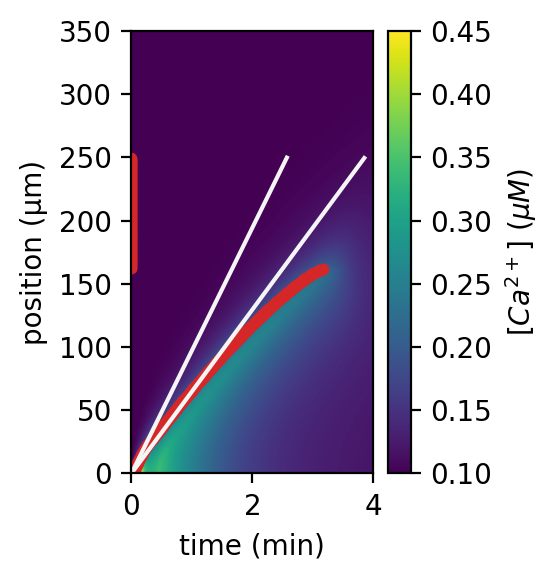

R-squared: 0.9917893395028295
wave velocity (in um/min): 51.43399508577007
wave travel distance (in um): 161.192083239


In [3]:
### Defining parameters to teh run the main model
dx = 0.2 
T = 4  
dt = 0.00001
theta0 = np.array([2.00270355e+02, 1.95119197e-01, 2.10012264e+00,
                   4.18697145e-01, 5.69583333e-01, 2.05740000e-01,
                   0.1, 2, 0.25])
vel, dis, rsq, ca1, ca2, ca3 = main_model_1(theta0, dx, dt, T, 'demo', include_sink = True)

- **Figure 2:** Ca$^{2+}$ concentration with time near the Ca$^{2+}$ channels at the start (top), midpoint (middle), and endpoint (bottom) of the total wave propagation distance. A horizontal red line indicates the half-maximum width within each plot. .

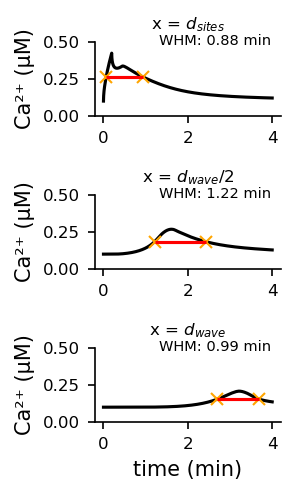

In [4]:
T = 4  
dt = 0.00001  
time_steps = int(T / dt)
time = np.linspace(0, T, time_steps)

fig, axs = plt.subplots(3, 1, figsize=(2, 3.4), dpi=150)

Ca_fired_list = [ca1, ca2, ca3]
labels = [r'x = $d_{sites}$', r'x = $d_{wave}$/2', r'x = $d_{wave}$']
colors = ['black', 'black', 'black']

for i, (Ca_fired, label, color) in enumerate(zip(Ca_fired_list, labels, colors)):
    axs[i].plot(time, Ca_fired, label=label, color=color)

    max_value = np.max(Ca_fired)
    max_time = time[np.argmax(Ca_fired)]
    half_max_value = 0.1 + (max_value - 0.1) / 2
    
    above_half_max = np.where(Ca_fired >= half_max_value)[0]
    half_max_rising_idx = above_half_max[0]  # First index where signal is >= half max
    half_max_falling_idx = above_half_max[-1]  # Last index where signal is >= half max
    
    half_max_rising_time = time[half_max_rising_idx]
    half_max_falling_time = time[half_max_falling_idx]
    
    axs[i].plot(half_max_rising_time, half_max_value, 'x', color='orange', label='Half Max (Rising)')
    axs[i].plot(half_max_falling_time, half_max_value, 'x', color='orange', label='Half Max (Falling)')
    width_at_half_max = half_max_falling_time - half_max_rising_time
    axs[i].hlines(half_max_value, half_max_rising_time, half_max_falling_time, color='red', linestyle='-', label='Width at Half Max')

    axs[2].set_xlabel('time (min)' , fontsize = 10)
    axs[i].set_ylabel('Ca²⁺ (µM)', fontsize = 10)
    axs[i].set_ylim(0,0.5)
    axs[i].set_title(label, fontsize = 8)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].tick_params(axis='x', labelsize=8)
    axs[i].tick_params(axis='y', labelsize=8)
    
    axs[i].text(0.95, 1.1, f'WHM: {width_at_half_max:.2f} min', 
                horizontalalignment='right', verticalalignment='top', 
                transform=axs[i].transAxes, fontsize=7)

plt.tight_layout()
plt.show()